#### ***Import Libraries***

# Bloque 1: Configuración e Importación de Librerías

En este bloque se importan las principales librerías que usaremos a lo largo del notebook:
- **Numpy y Pandas:** Para manipulación de datos.
- **Matplotlib:** Para las visualizaciones.
- **PyTorch:** Para definir y entrenar el modelo de recomendación.
- **Scikit-learn:** Para la división de datos y el cálculo de métricas.

Además, se configura el dispositivo de cómputo, utilizando GPU si está disponible.

In [1]:
# Bloque 1: Configuración e Importación de Librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configurar el dispositivo: usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


# Bloque 2: Carga y Preprocesamiento de Datos

En este bloque se realiza la carga del archivo `ratings.dat` y se aplica el preprocesamiento:
- Se filtran usuarios y películas con al menos 5 ratings.
- Se convierte el timestamp a formato datetime y se extraen características temporales (año, mes y día de la semana).
- Se normalizan los ratings dividiéndolos por 5 para que queden en el rango [0,1].

In [2]:
# Bloque 2: Carga y Preprocesamiento de Datos

# Cargar el dataset de ratings (asegúrate de que el archivo "ratings.dat" esté en el directorio actual o ajusta la ruta)
ratings = pd.read_csv("../data/ml-1m/ml-1m/ratings.dat", sep="::", engine="python", 
                        header=None, names=["UserID", "MovieID", "Rating", "Timestamp"])

# Mostrar las primeras filas y las dimensiones del dataset
print("Primeras 5 filas:")
print(ratings.head())
print("\nDimensiones del dataset:", ratings.shape)

# Filtrar usuarios con al menos 5 ratings
user_counts = ratings['UserID'].value_counts()
ratings = ratings[ratings['UserID'].isin(user_counts[user_counts >= 5].index)]

# Filtrar películas con al menos 5 ratings
movie_counts = ratings['MovieID'].value_counts()
ratings = ratings[ratings['MovieID'].isin(movie_counts[movie_counts >= 5].index)]

print("\nUsuarios después de filtrar:", ratings['UserID'].nunique())
print("Películas después de filtrar:", ratings['MovieID'].nunique())

# Convertir Timestamp a datetime y extraer características temporales
ratings['Datetime'] = pd.to_datetime(ratings['Timestamp'], unit='s')
ratings['Year'] = ratings['Datetime'].dt.year
ratings['Month'] = ratings['Datetime'].dt.month
ratings['DayOfWeek'] = ratings['Datetime'].dt.dayofweek

# Normalizar los ratings a [0,1]
ratings['Rating_Norm'] = ratings['Rating'] / 5.0

# Mostrar un resumen del preprocesamiento
print("\nResumen del preprocesamiento:")
print(ratings[['UserID', 'MovieID', 'Rating', 'Rating_Norm', 'Datetime', 'Year', 'Month', 'DayOfWeek']].head())

Primeras 5 filas:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

Dimensiones del dataset: (1000209, 4)

Usuarios después de filtrar: 6040
Películas después de filtrar: 3416

Resumen del preprocesamiento:
   UserID  MovieID  Rating  Rating_Norm            Datetime  Year  Month  \
0       1     1193       5          1.0 2000-12-31 22:12:40  2000     12   
1       1      661       3          0.6 2000-12-31 22:35:09  2000     12   
2       1      914       3          0.6 2000-12-31 22:32:48  2000     12   
3       1     3408       4          0.8 2000-12-31 22:04:35  2000     12   
4       1     2355       5          1.0 2001-01-06 23:38:11  2001      1   

   DayOfWeek  
0          6  
1          6  
2          6  
3          6  
4          5  


# Bloque 3: División Train/Validation/Test

Para evaluar correctamente nuestro modelo, dividiremos el dataset en tres conjuntos:
- **Train:** Datos para entrenar el modelo.
- **Validation:** Datos para ajustar hiperparámetros y aplicar early stopping.
- **Test:** Datos para evaluar el rendimiento final.

La división se realizará por usuario, ordenando los ratings cronológicamente, de manera que se simule un escenario real de predicción con datos históricos.

In [3]:
# Bloque 3: División Train/Validation/Test

# Para asegurarnos de que cada usuario tenga al menos 3 ratings,
# aunque ya filtramos por 5 en el preprocesamiento.
user_counts = ratings['UserID'].value_counts()
ratings_filtered = ratings[ratings['UserID'].isin(user_counts[user_counts >= 3].index)]

train_list, val_list, test_list = [], [], []

# Realizamos la división para cada usuario de forma independiente
for user_id, group in ratings_filtered.groupby('UserID'):
    # Ordenar los ratings por el timestamp (de más antiguo a más reciente)
    group = group.sort_values('Timestamp')
    
    # Dividir: 70% para entrenamiento, 30% para validación y test (dividido 50/50)
    train, temp = train_test_split(group, test_size=0.30, random_state=42)
    val, test = train_test_split(temp, test_size=0.50, random_state=42)
    
    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

# Combinar los datos de todos los usuarios
train_data = pd.concat(train_list).reset_index(drop=True)
val_data = pd.concat(val_list).reset_index(drop=True)
test_data = pd.concat(test_list).reset_index(drop=True)

print("Train size:", len(train_data))
print("Validation size:", len(val_data))
print("Test size:", len(test_data))

Train size: 697017
Validation size: 149779
Test size: 152815


# Bloque 4: Creación del Dataset Personalizado y DataLoaders

En este bloque se realiza lo siguiente:
- Se codifican los IDs de usuario y de película para transformarlos en índices numéricos, necesarios para las capas de embedding.
- Se define una clase `MovieLensDataset` (subclase de `torch.utils.data.Dataset`) que encapsula los datos.
- Se crean los DataLoaders para los conjuntos de entrenamiento, validación y test, permitiendo procesar los datos por lotes durante el entrenamiento.

In [4]:
# Bloque 4 (Modificado): Creación del Dataset Personalizado y DataLoaders

# Verificar si ya existen las columnas 'userIndex' y 'movieIndex', y crearlas si es necesario
if 'userIndex' not in ratings.columns:
    user_encoder = LabelEncoder()
    ratings['userIndex'] = user_encoder.fit_transform(ratings['UserID'])
    
if 'movieIndex' not in ratings.columns:
    movie_encoder = LabelEncoder()
    ratings['movieIndex'] = movie_encoder.fit_transform(ratings['MovieID'])

# Crear mapeos únicos para usuarios y películas
user_mapping = ratings[['UserID', 'userIndex']].drop_duplicates()
movie_mapping = ratings[['MovieID', 'movieIndex']].drop_duplicates()

# Fusionar usando los mapeos únicos para evitar duplicaciones
train_data = train_data.merge(user_mapping, on="UserID", how="left")
train_data = train_data.merge(movie_mapping, on="MovieID", how="left")
val_data = val_data.merge(user_mapping, on="UserID", how="left")
val_data = val_data.merge(movie_mapping, on="MovieID", how="left")
test_data = test_data.merge(user_mapping, on="UserID", how="left")
test_data = test_data.merge(movie_mapping, on="MovieID", how="left")

print("Usuarios codificados (train):", train_data['userIndex'].nunique())
print("Películas codificadas (train):", train_data['movieIndex'].nunique())

# Definir la clase Dataset
class MovieLensDataset(Dataset):
    def __init__(self, data):
        self.users = torch.tensor(data['userIndex'].values, dtype=torch.long)
        self.movies = torch.tensor(data['movieIndex'].values, dtype=torch.long)
        # Usamos el rating normalizado para facilitar el entrenamiento
        self.ratings = torch.tensor(data['Rating_Norm'].values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return {
            "user": self.users[idx],
            "movie": self.movies[idx],
            "rating": self.ratings[idx]
        }

# Crear instancias de los datasets
train_dataset = MovieLensDataset(train_data)
val_dataset = MovieLensDataset(val_data)
test_dataset = MovieLensDataset(test_data)

# Crear DataLoaders (ajustando num_workers a 0 para evitar problemas)
batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print("Tamaño del dataset de entrenamiento:", len(train_dataset))
print("Tamaño del dataset de validación:", len(val_dataset))
print("Tamaño del dataset de test:", len(test_dataset))

Usuarios codificados (train): 6040
Películas codificadas (train): 3415
Tamaño del dataset de entrenamiento: 697017
Tamaño del dataset de validación: 149779
Tamaño del dataset de test: 152815


# Bloque 5: Definición del Modelo Mejorado (NeuMF Mejorado)

En este bloque definimos la arquitectura del modelo mejorado basado en NeuMF. Se han realizado las siguientes mejoras:
- El camino MLP ahora cuenta con tres capas densas (fully-connected), aumentando la capacidad para capturar interacciones complejas.
- Se ha aumentado el tamaño de los embeddings para el camino MLP, lo que permite una representación más rica.
- Se han incorporado capas de Batch Normalization y Dropout en cada capa oculta para mejorar la estabilidad y evitar overfitting.
- Finalmente, se combinan las salidas de la rama GMF y la MLP para generar la predicción final.

In [5]:
# Bloque 5: Definición del Modelo Mejorado (NeuMF Mejorado)

class NeuMF(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim_gmf=32, embedding_dim_mlp=64, dropout=0.4):
        super(NeuMF, self).__init__()
        
        # Rama GMF
        self.user_embedding_gmf = nn.Embedding(num_users, embedding_dim_gmf)
        self.movie_embedding_gmf = nn.Embedding(num_movies, embedding_dim_gmf)
        
        # Rama MLP
        self.user_embedding_mlp = nn.Embedding(num_users, embedding_dim_mlp)
        self.movie_embedding_mlp = nn.Embedding(num_movies, embedding_dim_mlp)
        
        # Capas del MLP (tres capas)
        self.fc1 = nn.Linear(embedding_dim_mlp * 2, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.dropout = nn.Dropout(dropout)
        
        # Capa de salida: combinación de la salida de GMF y MLP
        self.output = nn.Linear(embedding_dim_gmf + 64, 1)
    
    def forward(self, user, movie):
        # Rama GMF: producto elemento a elemento de los embeddings
        user_gmf = self.user_embedding_gmf(user)
        movie_gmf = self.movie_embedding_gmf(movie)
        gmf_output = user_gmf * movie_gmf
        
        # Rama MLP: concatenación y paso por las capas fully-connected
        user_mlp = self.user_embedding_mlp(user)
        movie_mlp = self.movie_embedding_mlp(movie)
        mlp_input = torch.cat([user_mlp, movie_mlp], dim=1)
        
        x = self.fc1(mlp_input)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        # Combinar las dos ramas
        combined = torch.cat([gmf_output, x], dim=1)
        out = self.output(combined)
        return out.squeeze()

# Calcular el número correcto de usuarios y películas
num_users = train_data['userIndex'].max() + 1  # debería dar 6040
num_movies = train_data['movieIndex'].max() + 1  # debería dar 3416

# Inicializar el modelo con el número correcto de usuarios y películas
model = NeuMF(num_users=num_users, num_movies=num_movies, embedding_dim_gmf=32, embedding_dim_mlp=64, dropout=0.4)
model = model.to(device)
print(model)

NeuMF(
  (user_embedding_gmf): Embedding(6040, 32)
  (movie_embedding_gmf): Embedding(3416, 32)
  (user_embedding_mlp): Embedding(6040, 64)
  (movie_embedding_mlp): Embedding(3416, 64)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (output): Linear(in_features=96, out_features=1, bias=True)
)


# Bloque 6: Configuración del Entrenamiento

En este bloque se configura el proceso de entrenamiento:
- Se define la función de pérdida (MSELoss) y el optimizador (Adam) con regularización (weight decay).
- Se utiliza un scheduler para reducir la tasa de aprendizaje si la pérdida de validación no mejora.
- Se implementa un ciclo de entrenamiento con early stopping basado en la pérdida de validación.
- Se almacenan los valores de loss para poder visualizarlos posteriormente.

In [6]:
# Bloque 6: Configuración del Entrenamiento

num_epochs = 30
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

best_val_loss = float('inf')
patience = 5
early_stopping_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch in train_loader:
        users = batch['user'].to(device)
        movies = batch['movie'].to(device)
        ratings_batch = batch['rating'].to(device)
        
        # Predicción y cálculo de la pérdida
        preds = model(users, movies)
        loss = criterion(preds, ratings_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * len(ratings_batch)
    
    avg_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)
    
    # Validación
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            users = batch['user'].to(device)
            movies = batch['movie'].to(device)
            ratings_batch = batch['rating'].to(device)
            
            preds = model(users, movies)
            loss = criterion(preds, ratings_batch)
            running_val_loss += loss.item() * len(ratings_batch)
    
    avg_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping activado.")
            break

print("Entrenamiento completado.")

/home/eeguskiza/miniconda3/envs/work/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 - Train Loss: 0.0660 - Val Loss: 0.0462
Epoch 2/30 - Train Loss: 0.0412 - Val Loss: 0.0359
Epoch 3/30 - Train Loss: 0.0360 - Val Loss: 0.0342
Epoch 4/30 - Train Loss: 0.0349 - Val Loss: 0.0334
Epoch 5/30 - Train Loss: 0.0343 - Val Loss: 0.0328
Epoch 6/30 - Train Loss: 0.0336 - Val Loss: 0.0322
Epoch 7/30 - Train Loss: 0.0330 - Val Loss: 0.0320
Epoch 8/30 - Train Loss: 0.0326 - Val Loss: 0.0318
Epoch 9/30 - Train Loss: 0.0323 - Val Loss: 0.0317
Epoch 10/30 - Train Loss: 0.0320 - Val Loss: 0.0313
Epoch 11/30 - Train Loss: 0.0316 - Val Loss: 0.0310
Epoch 12/30 - Train Loss: 0.0313 - Val Loss: 0.0311
Epoch 13/30 - Train Loss: 0.0310 - Val Loss: 0.0308
Epoch 14/30 - Train Loss: 0.0307 - Val Loss: 0.0306
Epoch 15/30 - Train Loss: 0.0305 - Val Loss: 0.0305
Epoch 16/30 - Train Loss: 0.0303 - Val Loss: 0.0305
Epoch 17/30 - Train Loss: 0.0302 - Val Loss: 0.0304
Epoch 18/30 - Train Loss: 0.0300 - Val Loss: 0.0304
Epoch 19/30 - Train Loss: 0.0298 - Val Loss: 0.0304
Epoch 20/30 - Train L

# Bloque 7: Evaluación del Modelo

En este bloque:
- Se carga el mejor modelo (guardado durante el entrenamiento con early stopping).
- Se realiza la evaluación en el conjunto de test, calculando las métricas de regresión (RMSE, MAE, R²).
- Adicionalmente, se calculan métricas basadas en ranking: Precision@10 y NDCG@10.

In [7]:
# Bloque 7: Evaluación del Modelo

# Cargar el mejor modelo guardado (asegurarse de que se ha guardado previamente)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# Evaluación en el conjunto de test
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        users = batch['user'].to(device)
        movies = batch['movie'].to(device)
        ratings_batch = batch['rating'].to(device)
        
        preds = model(users, movies)
        y_true.extend(ratings_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calcular métricas de regresión: RMSE, MAE, R²
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("Métricas en el conjunto de test:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Evaluación de métricas basadas en ranking: Precision@10 y NDCG@10
from collections import defaultdict

k = 10
user_preds = defaultdict(list)
user_truth = defaultdict(list)

with torch.no_grad():
    for batch in test_loader:
        users = batch['user'].to(device)
        movies = batch['movie'].to(device)
        ratings_batch = batch['rating'].to(device)
        preds = model(users, movies)
        for u, pred, true in zip(users.cpu().numpy(), preds.cpu().numpy(), ratings_batch.cpu().numpy()):
            user_preds[u].append(pred)
            user_truth[u].append(true)

precisions = []
ndcgs = []

def ndcg_at_k(relevances, k):
    relevances = np.asarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    dcg = np.sum((2 ** relevances - 1) / np.log2(np.arange(2, relevances.size + 2)))
    ideal_relevances = np.sort(relevances)[::-1]
    idcg = np.sum((2 ** ideal_relevances - 1) / np.log2(np.arange(2, ideal_relevances.size + 2)))
    return dcg / idcg if idcg > 0 else 0.0

for u in user_preds:
    preds_u = np.array(user_preds[u])
    truths_u = np.array(user_truth[u])
    # Consideramos relevantes los ratings que, tras normalización, sean >= 0.8 (equivalente a rating >= 4)
    relevant = (truths_u >= 0.8)
    top_k_indices = np.argsort(-preds_u)[:k]
    num_relevant = np.sum(relevant[top_k_indices])
    precisions.append(num_relevant / k)
    
    # Para NDCG, usamos la relevancia binaria
    relevances = relevant.astype(int)
    top_k_relevances = relevances[np.argsort(-preds_u)[:k]]
    ndcgs.append(ndcg_at_k(top_k_relevances, k))

precision_at_k = np.mean(precisions)
ndcg_at_k_value = np.mean(ndcgs)

print(f"Precision@{k}: {precision_at_k:.4f}")
print(f"NDCG@{k}: {ndcg_at_k_value:.4f}")

Métricas en el conjunto de test:
RMSE: 0.1730
MAE: 0.1367
R²: 0.3974
Precision@10: 0.6485
NDCG@10: 0.9314


# Visualización: Evolución del Loss

Este gráfico muestra cómo evolucionaron las pérdidas (loss) en el conjunto de entrenamiento y validación a lo largo de las épocas. Esto nos ayuda a identificar si el modelo converge adecuadamente y si existe sobreajuste.

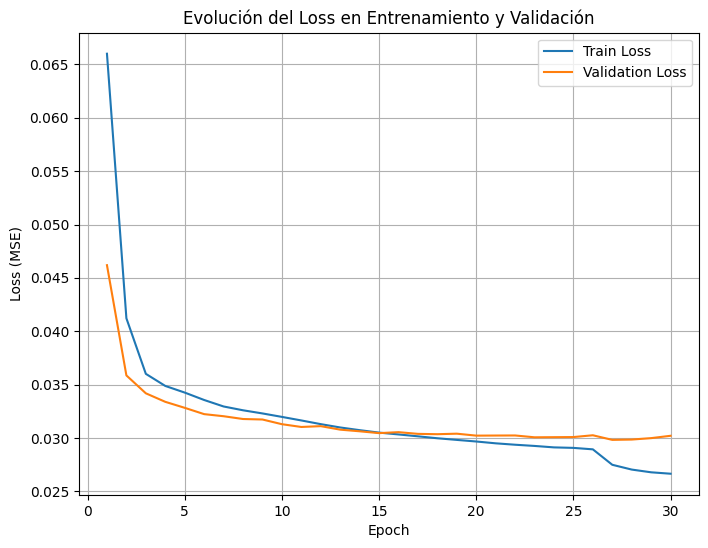

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Evolución del Loss en Entrenamiento y Validación')
plt.legend()
plt.grid(True)
plt.show()

# Visualización 1: Scatter Plot - Predicciones vs. Valores Reales

En este gráfico se representan los ratings reales (en escala [0,5]) frente a las predicciones del modelo. La línea diagonal indica el escenario ideal en el que la predicción es exactamente igual al valor real.

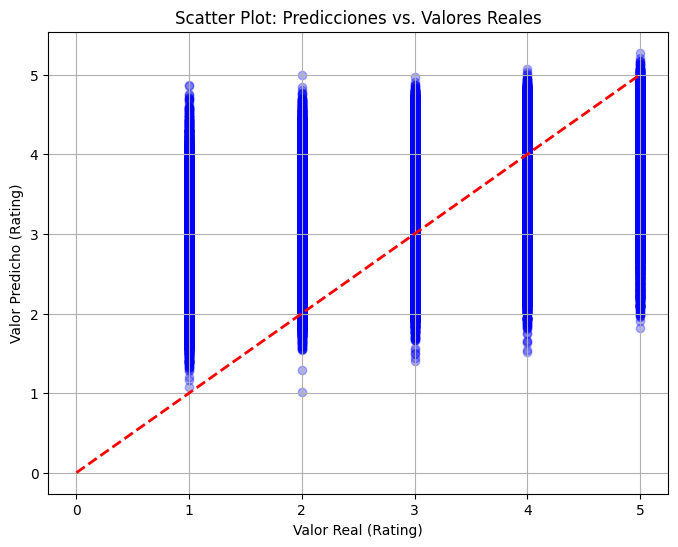

In [9]:
plt.figure(figsize=(8,6))
# Reescalamos las predicciones y valores reales multiplicándolos por 5 para volver a la escala original
plt.scatter(y_true * 5, y_pred * 5, alpha=0.3, color='blue')
plt.plot([0, 5], [0, 5], color='red', linestyle='--', linewidth=2)
plt.xlabel("Valor Real (Rating)")
plt.ylabel("Valor Predicho (Rating)")
plt.title("Scatter Plot: Predicciones vs. Valores Reales")
plt.grid(True)
plt.show()

# Visualización 2: Histograma de Errores

Aquí se observa la distribución de los errores (Valor Real - Valor Predicho). Un sesgo hacia la izquierda o derecha o una distribución con colas muy largas puede indicar problemas en la predicción para ciertos rangos.

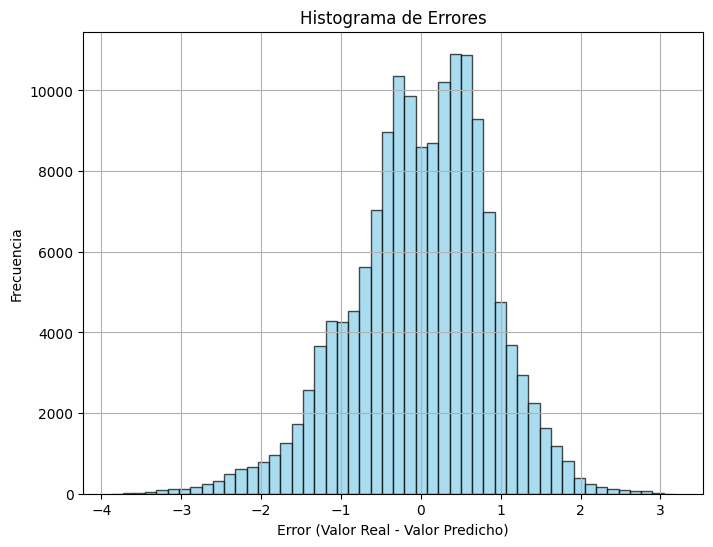

In [10]:
# Calcular errores en la escala original
errors = y_true * 5 - y_pred * 5

plt.figure(figsize=(8,6))
plt.hist(errors, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("Error (Valor Real - Valor Predicho)")
plt.ylabel("Frecuencia")
plt.title("Histograma de Errores")
plt.grid(True)
plt.show()

# Visualización 3: Residual Plot - Error vs. Predicción

Este plot muestra los residuos (diferencia entre el valor real y el predicho) en función de los valores predichos. La línea horizontal en cero indica el punto en el que la predicción es perfecta. Se busca que los errores estén distribuidos aleatoriamente alrededor de cero.

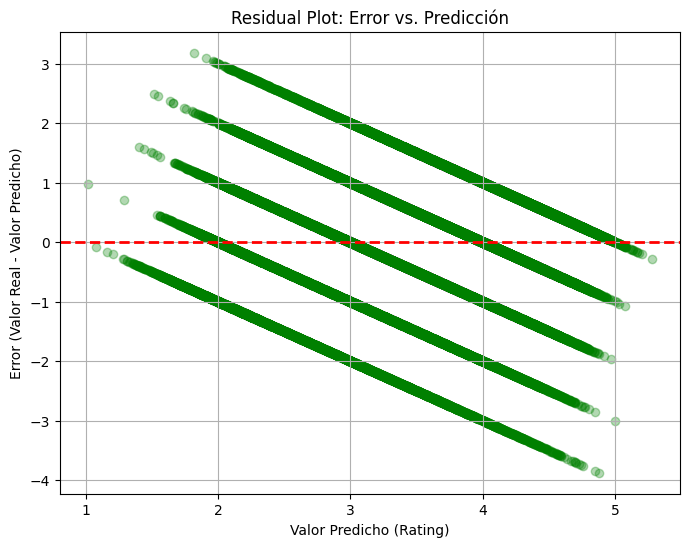

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(y_pred * 5, errors, alpha=0.3, color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Valor Predicho (Rating)")
plt.ylabel("Error (Valor Real - Valor Predicho)")
plt.title("Residual Plot: Error vs. Predicción")
plt.grid(True)
plt.show()